# Classification Methods

In [2]:
import random

random.seed(20231017)

In this tutorial, we will introduce four widely-used classification methods and how to use them in R programming language.

+ Logistic regression
+ LDA
+ QDA
+ KNN

We will also introduce the receiver operating characteristic curve (ROC curve) to evaluate the performances of the methods.

We use `Smarket` data from the `ISLP` library to demonstrate.

In [4]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [5]:
Smarket = load_data('Smarket')
# Get the dimensions of the DataFrame
print(Smarket.shape)

(1250, 9)


In [6]:
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [7]:
Smarket.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


## Logistic regression

Next, we will fit a logistic regression model in order to predict  `Direction` using  `Lag1` through `Lag5` and  `Volume`. The `sm.GLM()` function fits **generalized linear models**, a class of models that includes **logistic regression**. Alternatively, the function `sm.Logit()` fits a logistic regression model directly. The syntax of `sm.GLM()` is similar to that of `sm.OLS()`, except that we must pass in the argument `family=sm.families.Binomial()` in order to tell statsmodels to run a logistic regression rather than some other type of generalized linear model.

In [8]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [9]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

+ The `predict()` function can be used to predict the probability that the market will go up, given values of the predictors.

In [10]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

+ The logit values, e.g. $log(\frac{Pr(Y=1|X)}{Pr(Y=0|X)})$.

In [11]:
np.log(probs[:10] / (1 - probs[:10]))

array([ 0.02833843, -0.07416246, -0.07548048,  0.06090825,  0.04313134,
        0.02782764, -0.02939862,  0.03692083,  0.07048327, -0.0446563 ])

+ We can check the prediction performance by producing a table and compute the accuracy.

In [14]:
# Make predictions based on the probabilities
glm_pred = ['Up' if p > 0.5 else 'Down' for p in probs]
glm_pred[:6]

['Up', 'Down', 'Down', 'Up', 'Up', 'Up']

In [13]:
# True value
Smarket['Direction'][:6]

0      Up
1      Up
2    Down
3      Up
4      Up
5      Up
Name: Direction, dtype: category
Categories (2, object): ['Down', 'Up']

In [15]:
labels = np.array(['Down']*1250)
labels[probs>0.5] = "Up"
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [16]:
(507+145)/1250, np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

+ The accuracy only replects the performance under threshold 0.5. We can construct ROC curve to evaluate the general performance under various thresholding value.

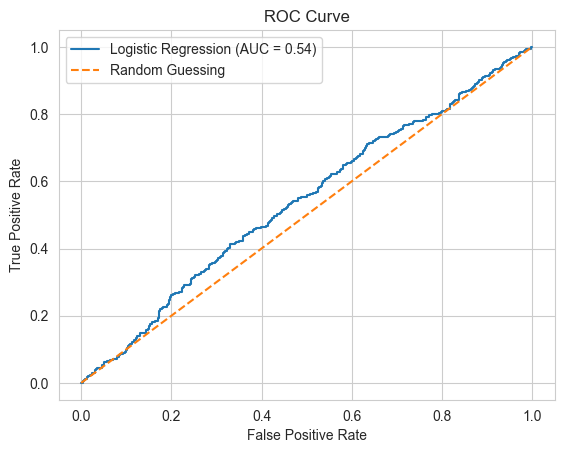

In [17]:
# Compute the ROC curve and AUC score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y, probs)
auc = roc_auc_score(y, probs)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

+ At first glance, it looks a little bit better than random guess. But this result is evaluated on the training set.
+ Intuitively, the test result will be worse due to the overfitting problem.
+ Let's fit the model using two independent datasets: fit the model using observations from 2001-2004; test the results using a held-out data of obserations from 2005.

In [18]:
# Split the data into training and test sets
train = Smarket['Year'] < 2005
test = Smarket['Year'] >= 2005

Smarket['Direction_bin'] = Smarket['Direction'].map({'Up': 1, 'Down': 0})

In [19]:
Smarket.loc[test, ].shape[0]

252

In [20]:
# Fit the logistic regression model on the training set
glm_fit = sm.Logit(Smarket.loc[train, 'Direction_bin'], sm.add_constant(Smarket.loc[train, ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']])).fit()

# Predict the probabilities on the test set
glm_probs = glm_fit.predict(sm.add_constant(Smarket.loc[test, ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]), linear=False)

# Make predictions based on the probabilities
glm_pred = ['Up' if p > 0.5 else 'Down' for p in glm_probs]

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


/Users/vvv/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


In [21]:
labels = np.array(['Down']*252)
labels[glm_probs>0.5] = "Up"
confusion_table(labels, Smarket.loc[test, 'Direction'])

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [22]:
print("The accuracy is now", np.mean(labels == Smarket.loc[test, 'Direction']), ".\n")

The accuracy is now 0.4801587301587302 .



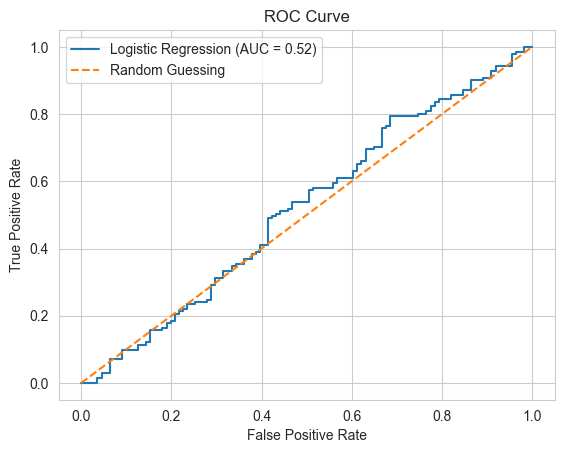

In [23]:
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(Smarket.loc[test, 'Direction_bin'], glm_probs)
auc = roc_auc_score(Smarket.loc[test, 'Direction_bin'], glm_probs)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

- Now, the test error rate is $52\%$, which is worse than random guessing!
- Prediction AUC is $0.52$, slightly better than random guess but worse than training AUC (as expected).
- We find descrepency between AUC and prediction accuracy, because the former accounts for the entire cutoff range.

- Of course this result is not all that surprising, given that one would not generally expect to be able to use previous days’ returns to predict future market performance.
- We recall that the logistic regression model had very underwhelming pvalues associated with all of the predictors, and that the smallest p-value, though not very small, corresponded to `Lag1`.
- Perhaps by removing the variables that appear not to be helpful in predicting `Direction`, we can obtain a more effective model.
- Below we have refit the logistic regression using just `Lag1` and `Lag2`, which seemed to have the highest predictive power in the original logistic regression model.

In [24]:
# Fit the logistic regression model on the training set
glm_fit = sm.Logit(Smarket.loc[train, 'Direction_bin'], sm.add_constant(Smarket.loc[train, ['Lag1', 'Lag2']])).fit()

# Predict the probabilities on the test set
glm_probs = glm_fit.predict(sm.add_constant(Smarket.loc[test, ['Lag1', 'Lag2']]), linear=False)

# Make predictions based on the probabilities
glm_pred = ['Up' if p > 0.5 else 'Down' for p in glm_probs]

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


/Users/vvv/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


In [21]:
labels = np.array(['Down']*252)
labels[glm_probs>0.5] = "Up"
confusion_table(labels, Smarket.loc[test, 'Direction'])

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [25]:
print("The accuracy is now", np.mean(labels == Smarket.loc[test, 'Direction']), ".\n")

The accuracy is now 0.4801587301587302 .



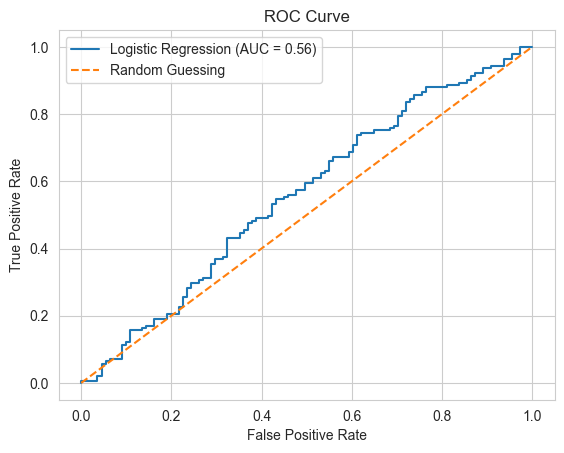

In [26]:
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(Smarket.loc[test, 'Direction_bin'], glm_probs)
auc = roc_auc_score(Smarket.loc[test, 'Direction_bin'], glm_probs)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## LDA
We begin by performing LDA on the `Smarket` data, using the function `LinearDiscriminantAnalysis()`. We fit the model using only the observations before 2005.

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Linear Discriminant Analysis
lda_fit = LinearDiscriminantAnalysis().fit(Smarket.loc[train, ['Lag1', 'Lag2']], Smarket.loc[train, 'Direction'])
print(lda_fit)

LinearDiscriminantAnalysis()


In [28]:
lda_fit.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [29]:
lda_fit.priors_

array([0.49198397, 0.50801603])

In [30]:
lda_fit.scalings_

array([[-0.64201904],
       [-0.51352928]])

- Prior probabilities: $\pi_k$.
- Group means: $\mu_k$.
- Coefficients: discrimination function $\mu^T \Sigma^{-1} x$ is linear on $x$.

In [31]:
sum(Smarket.loc[train, "Direction"] == "Up") / sum(train), sum(Smarket.loc[train, "Direction"] == "Down") / sum(train)

(0.5080160320641283, 0.49198396793587174)

- The LDA output indicates that $\pi_1 = 0.492$ and $\pi_2 = 0.508$; in other words, 49.2% of the training observations correspond to days during which the market went down. 
- It also provides the group means; these are the average of each predictor within each class, and are used by LDA as estimate of $\mu_k$. 
- These suggest that there is a tendency for the previous 2 days returns to be negative on days when the market increases, and a tendency for the previous days’ returns to be positive on days when the market declines.

In [32]:
# Make predictions on the test set
lda_pred = lda_fit.predict(Smarket.loc[test, ['Lag1', 'Lag2']])
lda_prob = lda_fit.predict_proba(Smarket.loc[test, ['Lag1', 'Lag2']])

In [33]:
confusion_table(lda_pred, Smarket.loc[test, 'Direction'])

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [34]:
print("The accuracy is now", np.mean(lda_pred == Smarket.loc[test, 'Direction']), ".\n")

The accuracy is now 0.5595238095238095 .



- The prediction performance is the same as logistic regression.

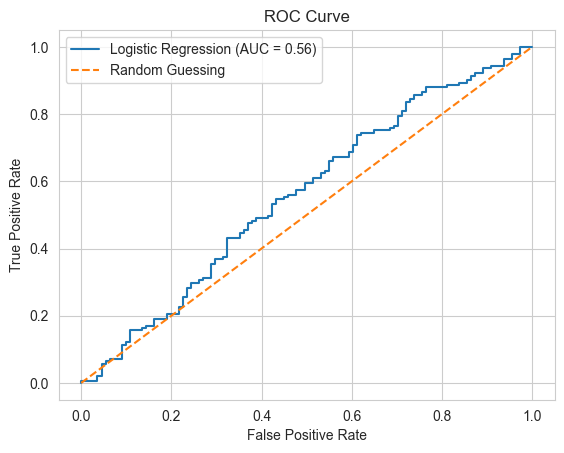

In [35]:
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(Smarket.loc[test, 'Direction_bin'], lda_prob[:,1])
auc = roc_auc_score(Smarket.loc[test, 'Direction_bin'], lda_prob[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## QDA
We will now fit a QDA model to the `Smarket` data. QDA is implemented via `QuadraticDiscriminantAnalysis()` in the `sklearn` package, which we abbreviate to `QDA()`. The syntax is very similar to `LDA()`.

In [36]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Quadratic Discriminant Analysis
qda_fit = QuadraticDiscriminantAnalysis().fit(Smarket.loc[train, ['Lag1', 'Lag2']], Smarket.loc[train, 'Direction'])

# Print the fitted model
print(qda_fit)

QuadraticDiscriminantAnalysis()


In [37]:
qda_fit.means_, qda_fit.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [38]:
# Make predictions on the test set
qda_pred = qda_fit.predict(Smarket.loc[test, ['Lag1', 'Lag2']])
qda_prob = qda_fit.predict_proba(Smarket.loc[test, ['Lag1', 'Lag2']])

In [39]:
confusion_table(qda_pred, Smarket.loc[test, 'Direction'])

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [40]:
print("The accuracy is now", np.mean(qda_pred == Smarket.loc[test, 'Direction']), "!\n")

The accuracy is now 0.5992063492063492 !



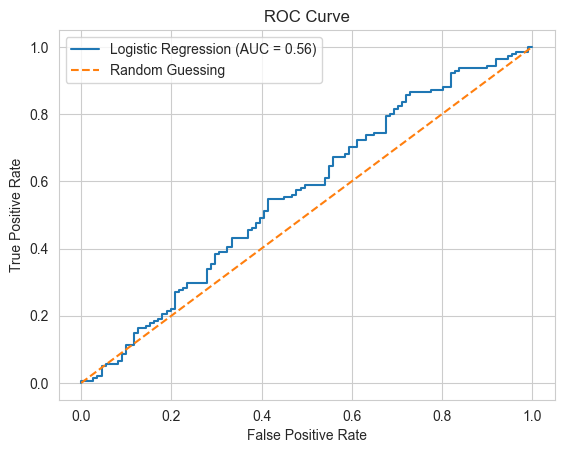

In [41]:
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(Smarket.loc[test, 'Direction_bin'], qda_prob[:,1])
auc = roc_auc_score(Smarket.loc[test, 'Direction_bin'], qda_prob[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Interestingly, the QDA predictions are accurate almost 60% of the time, even though the 2005 data was not used to fit the model. This level of accuracy is quite impressive for stock market data, which is known to be quite
hard to model accurately.
- This suggests that the quadratic form assumed by QDA may capture the true relationship more accurately than the linear forms assumed by LDA and logistic regression. 
- However, it would be better to evaluate this method’s performance on a larger test set before betting that this approach will consistently beat the market!

## K-Nearest Neighbors

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# K-Nearest Neighbors
knn_fit = KNeighborsClassifier(n_neighbors=1).fit(Smarket.loc[train, ['Lag1', 'Lag2']], Smarket.loc[train, 'Direction'])

# Make predictions on the test set
knn_pred = knn_fit.predict(Smarket.loc[test, ['Lag1', 'Lag2']])

# Compute the confusion matrix
conf_mat = confusion_matrix(Smarket.loc[test, 'Direction'], knn_pred)

# Print the confusion matrix and prediction accuracy
print('Confusion Matrix:')
print(conf_mat)
print('The prediction accuracy is', knn_fit.score(Smarket.loc[test, ['Lag1', 'Lag2']], Smarket.loc[test, 'Direction']))

Confusion Matrix:
[[43 68]
 [58 83]]
The prediction accuracy is 0.5


# Exercise

- Try to apply the KNN approach to the `Caravan` data set, which is part of the `ISLP` library. This data set includes 85 predictors that measure demographic characteristics for 5,822 individuals.

- Use `Purchase` as response.

In [43]:
Caravan = load_data('Caravan')
# Get the dimensions of the DataFrame
print(Caravan.shape)

# Print the first few rows of the DataFrame
print(Caravan.head())

(5822, 86)
   MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  MGODOV  \
0       33         1        3         2         8       0       5       1   
1       37         1        2         2         8       1       4       1   
2       37         1        2         2         8       0       4       2   
3        9         1        3         3         3       2       3       2   
4       40         1        4         2        10       1       4       1   

   MGODGE  MRELGE  ...  APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  APLEZIER  \
0       3       7  ...         0        0        0       1        0         0   
1       4       6  ...         0        0        0       1        0         0   
2       4       3  ...         0        0        0       1        0         0   
3       4       5  ...         0        0        0       1        0         0   
4       4       7  ...         0        0        0       1        0         0   

   AFIETS  AINBOED  ABYSTAND  Purchase 

In [44]:
# Standardize the predictors
standardized_X = (Caravan.iloc[:, :-1] - Caravan.iloc[:, :-1].mean()) / Caravan.iloc[:, :-1].std()

# Compute the variances of the first two predictors
print('Variance of predictor 1:', np.var(Caravan.iloc[:, 0]))
print('Variance of predictor 2:', np.var(Caravan.iloc[:, 1]))
print('Variance of standardized predictor 1:', np.var(standardized_X.iloc[:, 0]))
print('Variance of standardized predictor 2:', np.var(standardized_X.iloc[:, 1]))

# Split the data into training and test sets
test = np.arange(1000)
train_X = standardized_X.iloc[~test, :]
test_X = standardized_X.iloc[test, :]
train_Y = Caravan.iloc[~test, -1]
test_Y = Caravan.iloc[test, -1]

# K-Nearest Neighbors
knn_fit = KNeighborsClassifier(n_neighbors=1).fit(train_X, train_Y)

# Compute the misclassification rate
knn_pred = knn_fit.predict(test_X)
print('Misclassification rate:', np.mean(test_Y != knn_pred))

# Compute the error rate using the "No" class as the baseline
print('Error rate:', np.mean(test_Y != 'No'))

# Compute the confusion matrix and hit rate for k = 1
conf_mat = pd.crosstab(knn_pred, test_Y)
hit_rate = conf_mat.loc['Yes', 'Yes'] / (conf_mat.loc['Yes', 'Yes'] + conf_mat.loc['No', 'Yes'])
print('Confusion matrix (k = 1):')
print(conf_mat)
print('Hit rate (k = 1):', hit_rate)

# Repeat for k = 3
knn_fit = KNeighborsClassifier(n_neighbors=3).fit(train_X, train_Y)
knn_pred = knn_fit.predict(test_X)
conf_mat = pd.crosstab(knn_pred, test_Y)
hit_rate = conf_mat.loc['Yes', 'Yes'] / (conf_mat.loc['Yes', 'Yes'] + conf_mat.loc['No', 'Yes'])
print('Confusion matrix (k = 3):')
print(conf_mat)
print('Hit rate (k = 3):', hit_rate)

# Repeat for k = 5
knn_fit = KNeighborsClassifier(n_neighbors=5).fit(train_X, train_Y)
knn_pred = knn_fit.predict(test_X)
conf_mat = pd.crosstab(knn_pred, test_Y)
hit_rate = conf_mat.loc['Yes', 'Yes'] / (conf_mat.loc['Yes', 'Yes'] + conf_mat.loc['No', 'Yes'])
print('Confusion matrix (k = 5):')
print(conf_mat)
print('Hit rate (k = 5):', hit_rate)


Variance of predictor 1: 165.0095001180681
Variance of predictor 2: 0.16467949134763
Variance of standardized predictor 1: 0.9998282377189971
Variance of standardized predictor 2: 0.9998282377189966
Misclassification rate: 0.117
Error rate: 0.059
Confusion matrix (k = 1):
Purchase   No  Yes
row_0             
No        874   50
Yes        67    9
Hit rate (k = 1): 0.15254237288135594
Confusion matrix (k = 3):
Purchase   No  Yes
row_0             
No        920   56
Yes        21    3
Hit rate (k = 3): 0.05084745762711865
Confusion matrix (k = 5):
Purchase   No  Yes
row_0             
No        938   59
Yes         3    0
Hit rate (k = 5): 0.0
